In [1]:
import torch
from torch import nn
from torch import optim
from torchsummary import summary
from torch.autograd import Variable
from torch.nn import functional as F
from torch.optim import lr_scheduler
from torchvision import transforms, utils
from torch.utils.data import Dataset, random_split, DataLoader

import os
import yaml
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageDraw

torch.manual_seed(0)
np.random.seed(0)

torch.cuda.get_device_name()

'GeForce RTX 2080 SUPER'

In [2]:
with open('hyperparameters.yaml') as f:
    hp = yaml.safe_load(f)['hyperparameters']

In [3]:
base_path = './data/DermMel'

train_labels = pd.read_csv('./data/DermMel/train_labels.csv')
val_labels = pd.read_csv('./data/DermMel/val_labels.csv')
test_labels = pd.read_csv('./data/DermMel/test_labels.csv')

train_images = './data/DermMel/train/'
val_images = './data/DermMel/valid/'
test_images = './data/DermMel/test/'

In [4]:
train_labels.head()

,index,id,target
0,0,ISIC_0026529,0
1,1,AUG_0_3997,1
2,2,ISIC_0025285,0
3,3,ISIC_0033070,0
4,4,ISIC_0031685,0


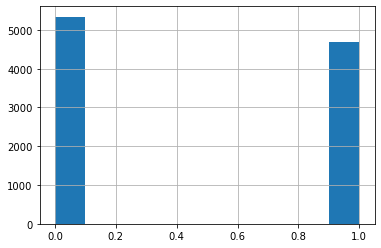

In [5]:
train_labels['target'].hist()

In [6]:
malignant_ids = train_labels.loc[train_labels['target'] == 1]['id'].values
benign_ids = train_labels.loc[train_labels['target'] == 0]['id'].values

print(f'Malignant: {malignant_ids[:15]}')
print(f'Normal: {benign_ids[:15]}')

Malignant: ['AUG_0_3997' 'AUGmented_0_6536' 'AUG_0_538' 'AUG_0_889'
 'AUGmented_0_8594' 'AUG_0_3968' 'AUG_0_3705' 'AUGmented_0_9575'
 'AUG_0_4955' 'AUGmented_0_8392' 'AUGmented_0_4221' 'AUG_0_9794'
 'AUG_0_4436' 'AUGmented_0_3310' 'AUG_0_1744']
Normal: ['ISIC_0026529' 'ISIC_0025285' 'ISIC_0033070' 'ISIC_0031685'
 'ISIC_0025945' 'ISIC_0026480' 'ISIC_0033720' 'ISIC_0028429'
 'ISIC_0033019' 'ISIC_0025574' 'ISIC_0026409' 'ISIC_0031825'
 'ISIC_0026673' 'ISIC_0028886' 'ISIC_0025801']


In [7]:
'''
this function scales down an image to 224 x 224 so that all images are uniform
in size, making it easy to feed to the model.

:param img: image used to scale down
'''
def scale_down(img):
    img = img.resize((int(img.size[0]/scale_factor), int(round(img.size[1]/scale_factor))))
    img = img.crop((37, 0, img.size[0] - 37, 224))
    return img

(224, 224)
(224, 224)
(224, 224)


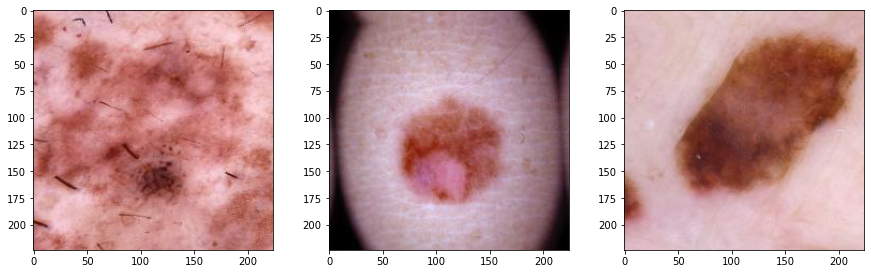

In [8]:
plt.rcParams['figure.figsize'] = (15., 15.)

for m_index, m_id in enumerate(malignant_ids[:3]):
    path = os.path.join(train_images, m_id + '.jpeg')
    img = Image.open(path)
    print(img.size)

    plt.subplot(3, 3, m_index + 1)
    plt.imshow(np.array(img))

(224, 224)
(224, 224)
(224, 224)


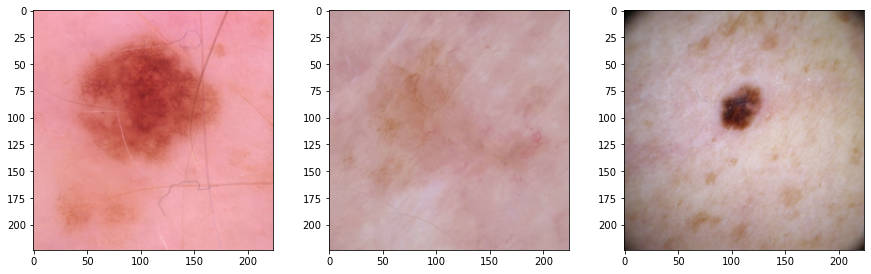

In [9]:
for m_index, m_id in enumerate(benign_ids[:3]):
    path = os.path.join(train_images, m_id + '.jpg')
    img = Image.open(path)

    scale_factor = img.size[1] / 224

    img = img.resize((int(img.size[0]/scale_factor), int(round(img.size[1]/scale_factor))))
    img = img.crop((37, 0, img.size[0] - 37, 224))

    print(img.size)
    plt.subplot(3, 3, m_index + 1)
    plt.imshow(np.array(img))

In [10]:
class MelanomaDataset(Dataset):
    def __init__(self, transform, type, csv: pd.DataFrame):
        path = os.path.join(base_path, type)
        filenames = os.listdir(path)
        self.full_filenames = [os.path.join(path, file) for file in filenames]
        labels_df = csv
        labels_df.set_index(['id'])

        self.csv = csv
        self.labels = labels_df['target']
        self.transform = transform

    def __len__(self):
        return len(self.csv) # 10020

    def __getitem__(self, idx):
        image = Image.open(self.full_filenames[idx])
        if image.size[0] == 600:
            image = scale_down(image)
        image = self.transform(image)
        return image, self.labels[idx]

In [11]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [12]:
train_ds = MelanomaDataset(transform, 'train', train_labels)
val_ds = MelanomaDataset(transform, 'valid', val_labels)

In [13]:
x = 231
print(train_ds.__getitem__(x)[0].shape)
print(train_ds.__getitem__(x)[1])

print(val_ds.__getitem__(x)[0].shape)
print(val_ds.__getitem__(x)[1])

torch.Size([3, 224, 224])
0
torch.Size([3, 224, 224])
1


In [14]:
print(f'Length of training dataset: {len(train_ds)}')
print(f'Length of validation dataset: {len(val_ds)}')

Length of training dataset: 10021
Length of validation dataset: 3349


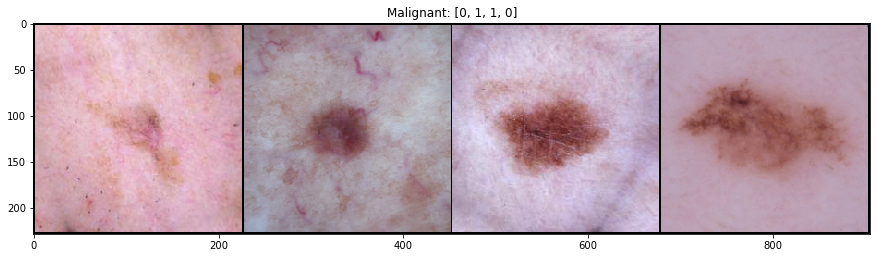

In [15]:
def show_img(img, labels):
    img = img.numpy()
    img = img.transpose(1, 2, 0)
    plt.imshow(img, interpolation='nearest')
    plt.title(f'Malignant: {labels}')

rand_i = np.random.randint(0, len(train_ds), 4)
imgs = [train_ds[i][0] for i in rand_i]
labels = [train_ds[i][1] for i in rand_i]

imgs = utils.make_grid(imgs, nrow=4)
plt.rcParams['figure.figsize'] = (15.0, 5)
show_img(imgs, labels)

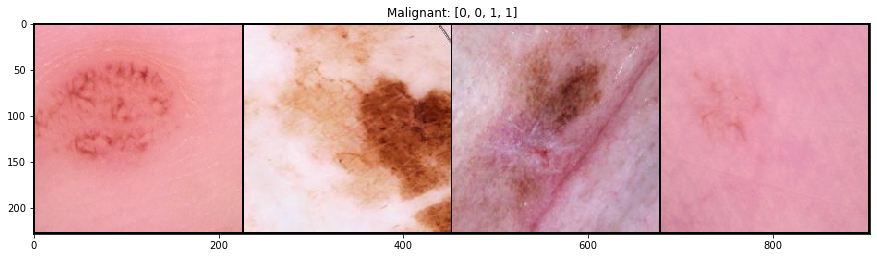

In [16]:
rand_i = np.random.randint(0, len(val_ds), 4)

imgs = utils.make_grid([val_ds[i][0] for i in rand_i], nrow=4)
labels = [val_ds[i][1] for i in rand_i]
show_img(imgs, labels)

In [17]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=.5)
    , transforms.RandomVerticalFlip(p=.5)
    , transforms.RandomRotation(45)
    , transforms.RandomResizedCrop(96, (0.8, 1.0), ratio=(1., 1.))
    , transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.ToTensor()
])

In [18]:
batch_size = hp['batch_size']

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [19]:
for x, _ in train_dl:
    x = x.shape
    print(f'Batch size: {x[0]}, Channels: {x[1]}, Width: {x[2]}, Height: {x[3]}')
    break

Batch size: 32, Channels: 3, Width: 224, Height: 224


In [20]:
for x, _ in val_dl:
    x = x.shape
    print(f'Batch size: {x[0]}, Channels: {x[1]}, Width: {x[2]}, Height: {x[3]}')
    break

Batch size: 32, Channels: 3, Width: 224, Height: 224


In [21]:
'''
used to calculate convolution layer size (in order to flatter)

:param h: input height
:param w: input width
:param conv: Conv2d object
:param pool: pooling size
'''
def get_conv_size(h, w, conv: nn.Conv2d, pool=1):
    size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation

    h = np.floor((h + 2 * padding[0] - dilation[0] * (size[0] - 1) - 1) / stride[0] + 1) / pool
    w = np.floor((w + 2 * padding[1] - dilation[1] * (size[1] - 1) - 1) / stride[1] + 1) / pool

    return int(h), int(w)

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        input_channels, input_height, input_width = hp['input_shape']
        output_classes = hp['output_classes']

        out_1, kernel_1, stride_1, padding_1 = hp['conv1']
        out_2, kernel_2, stride_2, padding_2 = hp['conv2']
        out_3, kernel_3, stride_3, padding_3 = hp['conv3']
        out_4, kernel_4, stride_4, padding_4 = hp['conv4']
        out_5, kernel_5, stride_5, padding_5 = hp['conv5']

        linear_1 = hp['linear_1']
        linear_2 = hp['linear_2']
        linear_3 = hp['linear_3']
        dropout = hp['dropout']

        self.conv_1 = nn.Conv2d(input_channels, out_1, kernel_size=kernel_1, stride=stride_1, padding=padding_1)
        self.conv_2 = nn.Conv2d(out_1, out_2, kernel_size=kernel_2, stride=stride_2, padding=padding_2)
        self.conv_3 = nn.Conv2d(out_2, out_3, kernel_size=kernel_3, stride=stride_3, padding=padding_3)
        self.conv_4 = nn.Conv2d(out_3, out_4, kernel_size=kernel_4, stride=stride_4, padding=padding_4)
        self.conv_5 = nn.Conv2d(out_4, out_5, kernel_size=kernel_5, stride=stride_5, padding=padding_5)

        h, w = get_conv_size(input_height, input_width, self.conv_1, pool=2)
        h, w = get_conv_size(h, w, self.conv_2, pool=2)
        h, w = get_conv_size(h, w, self.conv_3, pool=2)
        h, w = get_conv_size(h, w, self.conv_4, pool=2)
        h, w = get_conv_size(h, w, self.conv_5, pool=2)
        self.flat = h * w * out_5

        self.features = nn.Sequential(
            # block 1
            self.conv_1
            , nn.BatchNorm2d(out_1)
            , nn.ReLU()
            , nn.MaxPool2d(2, 2)

            # block 2
            , self.conv_2
            , nn.BatchNorm2d(out_2)
            , nn.ReLU()
            , nn.MaxPool2d(2, 2)

            # block 3
            , self.conv_3
            , nn.BatchNorm2d(out_3)
            , nn.ReLU()
            , nn.MaxPool2d(2, 2)

            # block 4
            , self.conv_4
            , nn.BatchNorm2d(out_4)
            , nn.ReLU()
            , nn.MaxPool2d(2, 2)

            # block 5
            , self.conv_5
            , nn.BatchNorm2d(out_5)
            , nn.ReLU()
            , nn.MaxPool2d(2, 2)
        )

        self.classfier = nn.Sequential(
            # block 1
            nn.Linear(self.flat, linear_1)
            , nn.BatchNorm1d(linear_1)
            , nn.ReLU()

            # block 2
            , nn.Linear(linear_1, linear_2)
            , nn.BatchNorm1d(linear_2)
            , nn.ReLU()

            # block 3
            , nn.Linear(linear_2, linear_3)
            , nn.BatchNorm1d(linear_3)
            , nn.ReLU()

            , nn.Dropout(p=dropout)

            # output
            , nn.Linear(linear_3, output_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, self.flat)
        x = self.classfier(x)
        return F.log_softmax(x, dim=1)

net = Net().cuda()

In [23]:
net

Net(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_5): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3)

In [24]:
summary(net, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
            Conv2d-2         [-1, 64, 224, 224]           1,792
       BatchNorm2d-3         [-1, 64, 224, 224]             128
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
            Conv2d-7        [-1, 128, 112, 112]          73,856
       BatchNorm2d-8        [-1, 128, 112, 112]             256
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
           Conv2d-12          [-1, 256, 56, 56]         295,168
      BatchNorm2d-13          [-1, 256, 56, 56]             512
             ReLU-14          [-1, 256,

In [25]:
mode, factor, patience = hp['lr_scheduler']

loss = nn.NLLLoss(reduction='sum')
optimizer = optim.Adam(params=net.parameters(), lr=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode=mode, factor=factor, patience=patience, verbose=1)

In [26]:
'''
predicts number of correct predictions per batch

:param output: output tensor of model
:param target: correct answers
'''
def batch_metrics(output: torch.Tensor, target: torch.Tensor):
    pred = output.argmax(dim=1, keepdim=True)
    num_correct = pred.eq(target.view_as(pred)).sum().item()
    return num_correct

In [27]:
'''
calculates overall loss for batch

:param loss_func: loss function of model
:param output: output tensor of model
:param target: correct answers
:param optimizer: optimizer function of model
'''
def batch_loss(loss_func, output: torch.Tensor, target: torch.Tensor, optimizer=None):
    loss = loss_func(output, target)

    with torch.no_grad():
        metrics = batch_metrics(output, target)

    if optimizer is not None:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item(), metrics

In [28]:
'''
calculates overall loss and performance for epoch

:param net: the neural network itself
:param loss_func: loss function of model
:param dataloader: current dataloader being used
:param sanity_check: option for data sanity check
:param optimizer: optimizer function of model
'''
def epoch_loss(net:Net, loss_func, dataloader:DataLoader, sanity_check, optimizer=None):
    running_loss = 0.
    running_metric = 0.
    size = len(dataloader.dataset)

    # loop over batch
    for X_b, y_b in dataloader:
        X_b = X_b.cuda()
        y_b = Variable(y_b).cuda()

        # get predictions
        out = net(X_b)
        out = Variable(out)

        # get batch loss and metrics
        loss_b, metrics_b = batch_loss(loss_func, out, y_b, optimizer)

        # update running loss and accuracy
        running_loss += loss_b
        if metrics_b is not None:
            running_metric += metrics_b

        if sanity_check:
            break

    # calculate overall loss and metric
    loss, metric = running_loss / float(size), running_metric / float(size)

    return loss, metric

In [29]:
def train(model: Net, params):
    # load train / val parameters
    epochs = params['epochs']
    loss = params['loss']
    optimizer = params['optimizer']
    train_dl = params['train_dl']
    val_dl = params['val_dl']
    scheduler = params['scheduler']
    sanity_check = params['sanity_check']
    weights_save = params['weights_save']

    # create history object for plotting model performance
    history = {
        'loss':{
            'train': [],
            'val': []
        },
        'metric':{
            'train': [],
            'val': []
        }
    }

    # save best model weights
    best_weights = copy.deepcopy(model.state_dict())
    best_loss = float('inf') # set baseline best loss

    # train and val loop
    for epoch in range(epochs):
        lr = optimizer.param_groups[0]['lr']
        print(f'Epoch: {epoch + 1}/{epochs} \t Learning Rate: {lr}')

        model.train()
        loss_t, metric_t = epoch_loss(model, loss, train_dl, sanity_check, optimizer)

        history['loss']['train'].append(loss_t)
        history['metric']['train'].append(metric_t)

        model.eval()
        with torch.no_grad():
            loss_v, metric_v = epoch_loss(model, loss, val_dl, sanity_check, optimizer)

        history['loss']['val'].append(loss_v)
        history['metric']['val'].append(metric_v)

        if loss_v < best_loss:
            best_loss = loss_v
            best_weights = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), weights_save)
            print(f'-- Saving optimal weights - Loss: {best_loss:.2f}... --')

        scheduler.step(loss_v)
        if lr is not optimizer.param_groups[0]['lr']:
            model.load_state_dict(best_weights)
            print('-- Loading optimal weights... --')

        print(f'Train loss: {loss_t:.2f} \t Val loss: {loss_v:.2f} \t Accuracy: {metric_v * 100 :.2f}')
        print('\n'+ '-' * 15)

    model.load_state_dict(best_weights)

    return model, history

In [30]:
for x, y in train_dl:
    print(y)
    break

tensor([0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 1, 0])


In [ ]:
train_params = {
    'epochs': hp['epochs'],                 # epochs
    'loss': loss,                           # loss function
    'optimizer': optimizer,                 # optimizer
    'train_dl': train_dl,                   # train DataLoader
    'val_dl': val_dl,                       # val DataLoader
    'scheduler': scheduler,                 # learning rate scheduler
    'sanity_check': True,                   # sanity check toggle
    'weights_save': './models/weights.pt'   # output location of saved model weights
}

net, history = train(net, train_params)